# Analiza statistica


In [ ]:
#%pip install scikit-learn
#%pip install linearmodels

In [6]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
# ------------------------------------------
# 0) IMPORTURI
# ------------------------------------------
import pandas as pd
import numpy as np
from linearmodels.panel import PanelOLS
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
df = pd.read_csv("../data/all_energy_data.csv")
df2023 = df[df.year == 2023]

# PCA

In [3]:
vars_pca = df2023[[
    "gdp_per_capita","energy_use_pc","co2_pc",
    "renewables_generation","coal_generation"
]].dropna()

In [4]:

X = StandardScaler().fit_transform(vars_pca)
pca = PCA(n_components=2)
pc = pca.fit_transform(X)


# Regresie simpla

In [5]:
import statsmodels.api as sm

dfreg = df2023[["co2_pc","gdp_per_capita"]].dropna()
X = sm.add_constant(dfreg["gdp_per_capita"])
model = sm.OLS(dfreg["co2_pc"], X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                 co2_pc   R-squared:                       0.290
Model:                            OLS   Adj. R-squared:                  0.286
Method:                 Least Squares   F-statistic:                     67.84
Date:                Thu, 11 Dec 2025   Prob (F-statistic):           5.04e-14
Time:                        11:27:19   Log-Likelihood:                -532.59
No. Observations:                 168   AIC:                             1069.
Df Residuals:                     166   BIC:                             1075.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              2.1689      0.557      3.

# Regression with fixed effects

In [7]:
energy = df.copy()

In [8]:
# energy trebuie să fie deja pivotat wide, cum l-ai construit:
# energy = df_clean.pivot_table(...)

# Cream share-urile dacă nu există deja
energy["coal_share"] = energy["coal_generation"] / energy["electricity_generation"]
energy["renewables_share"] = energy["renewables_generation"] / energy["electricity_generation"]
energy["gas_share"] = energy["natural_gas_generation"] / energy["electricity_generation"]
energy["oil_share"] = energy["oil_generation"] / energy["electricity_generation"]


In [9]:
# CO₂ = million metric tonnes → transformăm în tone
energy["co2_pc"] = (energy["co2_emissions_emissions"] * 1e6) / energy["population_total"]


In [10]:
panel = energy[[
    "country", "year",
    "coal_share", "renewables_share", "co2_pc",
    "gdp_per_capita", "gov_effectiveness"
]].copy()
panel = panel.dropna()
print("Dimensiune panel curat:", panel.shape)
panel = panel.set_index(["country", "year"])


Dimensiune panel curat: (3776, 7)


In [11]:
X = panel[["gdp_per_capita", "gov_effectiveness"]]
X = sm.add_constant(X)

In [12]:
# MODEL 1 — Effecte fixe: PIB + instituții → Renewables Share
y_re = panel["renewables_share"]

mod_re = PanelOLS(
    dependent=y_re,
    exog=X,
    entity_effects=True,
    time_effects=True
)

res_re = mod_re.fit(cov_type="clustered", cluster_entity=True)
print(res_re)


                          PanelOLS Estimation Summary                           
Dep. Variable:       renewables_share   R-squared:                        0.0335
Estimator:                   PanelOLS   R-squared (Between):             -0.0459
No. Observations:                3776   R-squared (Within):               0.0611
Date:                Thu, Dec 11 2025   R-squared (Overall):             -0.0373
Time:                        11:29:56   Log-likelihood                    3509.4
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      62.057
Entities:                         173   P-value                           0.0000
Avg Obs:                       21.827   Distribution:                  F(2,3580)
Min Obs:                      10.0000                                           
Max Obs:                       22.000   F-statistic (robust):             5.6108
                            

In [13]:
# MODEL 2 — Effecte fixe: PIB + instituții → Coal Share
y_coal = panel["coal_share"]

mod_coal = PanelOLS(
    dependent=y_coal,
    exog=X,
    entity_effects=True,
    time_effects=True
)

res_coal = mod_coal.fit(cov_type="clustered", cluster_entity=True)
print(res_coal)


                          PanelOLS Estimation Summary                           
Dep. Variable:             coal_share   R-squared:                        0.0487
Estimator:                   PanelOLS   R-squared (Between):              0.0425
No. Observations:                3776   R-squared (Within):               0.0582
Date:                Thu, Dec 11 2025   R-squared (Overall):              0.0431
Time:                        11:30:04   Log-likelihood                    5633.9
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      91.579
Entities:                         173   P-value                           0.0000
Avg Obs:                       21.827   Distribution:                  F(2,3580)
Min Obs:                      10.0000                                           
Max Obs:                       22.000   F-statistic (robust):             8.3759
                            

In [14]:
# yODEL 3 — Effecte fixe: PIB + instituții → CO₂ per capita# 
y_co2 = panel["co2_pc"]

mod_co2 = PanelOLS(
    dependent=y_co2,
    exog=X,
    entity_effects=True,
    time_effects=True
)

res_co2 = mod_co2.fit(cov_type="clustered", cluster_entity=True)
print(res_co2)


                          PanelOLS Estimation Summary                           
Dep. Variable:                 co2_pc   R-squared:                        0.0226
Estimator:                   PanelOLS   R-squared (Between):              0.1512
No. Observations:                3776   R-squared (Within):               0.0209
Date:                Thu, Dec 11 2025   R-squared (Overall):              0.1463
Time:                        11:30:12   Log-likelihood                   -6325.5
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      41.424
Entities:                         173   P-value                           0.0000
Avg Obs:                       21.827   Distribution:                  F(2,3580)
Min Obs:                      10.0000                                           
Max Obs:                       22.000   F-statistic (robust):             6.3764
                            

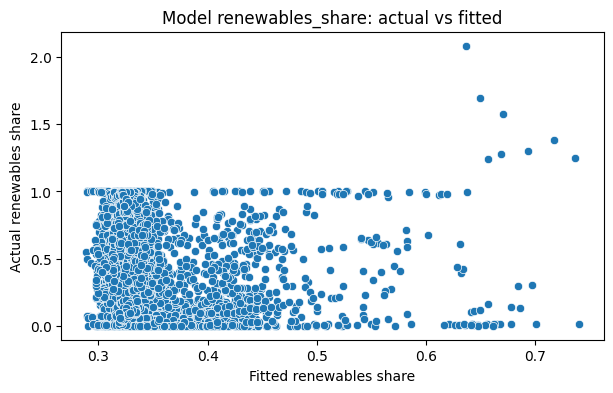

In [15]:
fitted = res_re.fitted_values.to_numpy().ravel()
actual = y_re.to_numpy().ravel()

plt.figure(figsize=(7,4))
sns.scatterplot(x=fitted, y=actual)
plt.xlabel("Fitted renewables share")
plt.ylabel("Actual renewables share")
plt.title("Model renewables_share: actual vs fitted")
plt.show()


In [19]:
def interpret_fe_model(model, dependent_name):
    print("="*80)
    print(f"INTERPRETAREA MODELULUI PANEL PENTRU: {dependent_name.upper()}")
    print("="*80)
    
    # ---------------- COEFICIENȚI ----------------
    print("\n--- COEFICIENȚI ---")
    print(model.params)
    
    print("\n--- VALORI p ---")
    print(model.pvalues)
    
    print("\n--- SEMNEFICAȚIE (*** p<0.01, ** p<0.05, * p<0.10) ---")
    for param, p in model.pvalues.items():
        if p < 0.01: sig = "***"
        elif p < 0.05: sig = "**"
        elif p < 0.10: sig = "*"
        else: sig = ""
        print(f"{param:25s} p = {p:.4f} {sig}")
    
    # ---------------- INTERPRETARE ECONOMICĂ ----------------
    print("\n--- INTERPRETARE ECONOMICĂ ---")
    for param, coef in model.params.items():
        if param == "const":
            continue
        
        sign = "pozitiv" if coef > 0 else "negativ"
        print(f"\n• {param}: coeficient {coef:.4f} ({sign})")

        if "gdp" in param:
            print("  → Economie: țările cu PIB/capita mai mare tind să modifice variabila dependentă "
                  f"în sens {'ascendent' if coef>0 else 'descendent'}.")

        if "gov" in param:
            print("  → Instituții: guvernanța influențează variabila dependentă "
                  f"în sens {'ascendent' if coef>0 else 'descendent'}.")
    
    # ---------------- EFECTE FIXE ----------------
    print("\n--- EFECTE FIXE ÎN MODEL ---")
    # verificăm dacă modelul original avea FE
    try:
        if model.model.entity_effects:
            print("• Efecte fixe pe țări: DA (controlează caracteristicile permanente ale țărilor).")
        else:
            print("• Efecte fixe pe țări: NU")
    except:
        pass

    try:
        if model.model.time_effects:
            print("• Efecte fixe pe ani: DA (controlează șocurile globale).")
        else:
            print("• Efecte fixe pe ani: NU")
    except:
        pass
    
    # ---------------- R-SQUARED ----------------
    print("\n--- R-SQUARED ---")
    print(f"Within R²:   {model.rsquared_within:.3f}")
    print(f"Between R²:  {model.rsquared_between:.3f}")
    print(f"Overall R²:  {model.rsquared_overall:.3f}")
    
    # ---------------- CONCLUZIE ----------------
    print("\n--- CONCLUZIE GENERALĂ ---")
    
    dep = dependent_name.lower()
    if dep == "renewables_share":
        print("Modelul arată cum economia și instituțiile influențează ritmul de creștere al regenerabilelor.")
    if dep == "coal_share":
        print("Modelul arată cum factorii economici și instituționali reduc sau mențin dependența de cărbune.")
    if dep == "co2_pc":
        print("Modelul arată dacă dezvoltarea și instituțiile reduc sau amplifică emisiile per capita.")
    
    print("="*80)


# K means clustering

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# selectăm doar 2023
dfc = energy[energy.year == 2023].copy()

# variabilele relevante pentru regimul energetic
vars_cluster = [
    "coal_share",
    "gas_share",
    "oil_share",
    "renewables_share",
    "co2_pc",
    "gdp_per_capita",
    "energy_use_pc"
]

dfc = dfc.dropna(subset=vars_cluster)

X = dfc[vars_cluster].values

# standardizare
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [ ]:
inertia = []
K = range(2, 8)

for k in K:
    km = KMeans(n_clusters=k, random_state=0)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.plot(K, inertia, marker='o')
plt.xlabel("k")
plt.ylabel("Inertia")
plt.title("Elbow method")
plt.show()


## Rulăm K-means cu 4 clustere (cel mai comun în energie)

In [18]:
kmeans = KMeans(n_clusters=4, random_state=0)
dfc["cluster"] = kmeans.fit_predict(X_scaled)

NameError: name 'KMeans' is not defined

In [ ]:
cluster_summary = dfc.groupby("cluster")[vars_cluster].mean().round(3)
cluster_summary

In [ ]:
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
coords = pca.fit_transform(X_scaled)

dfc["PC1"] = coords[:,0]
dfc["PC2"] = coords[:,1]

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=dfc,
    x="PC1",
    y="PC2",
    hue="cluster",
    palette="tab10",
    s=80
)

plt.title("Țările grupate după mixul energetic (KMeans, 2023)")
plt.show()


In [ ]:
countries_by_cluster = dfc[["country", "cluster"]].sort_values("cluster")
countries_by_cluster
dfc[["country",  "cluster"]].sort_values("cluster")
